### 4. Modeling

In [1]:
from pathlib import Path
import pandas as pd

path = Path("./modeling.ipynb")
abs_path = str(path.parent.absolute())
index = [i for i, e in enumerate(abs_path) if e == "\\"]      
parent_path = abs_path[:index[-2]]
train_path = parent_path + "/data/processed/train.csv"
test_path = parent_path + "/data/processed/test.csv"

data = pd.read_csv(train_path)
final_test = pd.read_csv(test_path)
y = data['SalePrice']
data =  data.drop('SalePrice',axis=1)
test_id = final_test['Id']

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.05, random_state = 42)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
import numpy as np

tf_imputer = ColumnTransformer([("imputer", SimpleImputer(missing_values=np.nan, strategy = 'mean'), [0,1,2,3,4,5,6])])

pre_pipeline = Pipeline(steps = ([("tf_imputer", tf_imputer),
                                ('scaler', MinMaxScaler(feature_range = (0,1)))]))

Methods are considered:
1. K-nearest-neighbors, 
2. Decision tree, 
3. Random forest, 
4. 2 SVM methods (using a polynomial kernel and a Gaussian kernel),
5. 2 (deep) neural networks with Sigmoid activation and ReLu activation functions
6. Xgboost

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone
from sklearn.metrics import r2_score, mean_absolute_error

## 1. KNN

In [5]:
from sklearn.neighbors import KNeighborsClassifier
knn_base = clone(pre_pipeline)
knn_base.steps.append(('knn', KNeighborsClassifier()))
knn_base.fit(X_train, y_train)

y_pred = knn_base.predict(X_test)
r2_base = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Performance for KNN baseline model is:")
print("---------------------------------------------")
print('R2 score is {}'.format(r2_base))
print('MAE is {}'.format(mae))

Performance for KNN baseline model is:
---------------------------------------------
R2 score is 0.6966016612071357
MAE is 28799.465753424658


In [6]:
pipeline = clone(pre_pipeline)
pipeline.steps.append(('knn', KNeighborsClassifier()))
param_dist = {"knn__n_neighbors": list(np.linspace(2, 7, 6, dtype = int)),
              "knn__leaf_size": list(np.linspace(5, 150, 5, dtype = int)),
              "knn__weights": ["uniform", "distance"],
              "knn__p": [1, 2, 3]}
random_search = RandomizedSearchCV(estimator = pipeline, param_distributions = param_dist, n_jobs = -1, verbose = 2, cv = 3)
random_search.fit(X_train, y_train)
knn_improve = random_search.best_estimator_

y_pred = knn_improve.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
improve =  (r2 - r2_base) / r2_base
print("Performance for KNN tuned model is:")
print("---------------------------------------------")
print('R2 score is {}'.format(r2))
print('MAE is {}'.format(mae))
print('Improvement of R2 score: {:0.2f}%.'.format( 100 * improve))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\flywi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Performance for KNN tuned model is:
---------------------------------------------
R2 score is 0.8092504113885084
MAE is 21363.369863013697
Improvement of R2 score: 16.17%.


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


In [7]:
random_search.best_params_

{'knn__weights': 'distance',
 'knn__p': 1,
 'knn__n_neighbors': 4,
 'knn__leaf_size': 41}

## 2. Decision tree

In [8]:
from sklearn import tree
dt_base = clone(pre_pipeline)
dt_base.steps.append(('dt', tree.DecisionTreeClassifier(random_state = 42)))
dt_base.fit(X_train, y_train)

y_pred = dt_base.predict(X_test)
r2_base = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Performance for Decision Tree baseline model is:")
print("---------------------------------------------")
print('R2 score is {}'.format(r2_base))
print('MAE is {}'.format(mae))

Performance for Decision Tree baseline model is:
---------------------------------------------
R2 score is 0.6856229361149115
MAE is 26167.479452054795


In [9]:
pipeline = clone(pre_pipeline)
pipeline.steps.append(('dt', tree.DecisionTreeClassifier(random_state = 42)))
param_dist = {"dt__criterion": ["gini", "entropy"],
              "dt__splitter": ["best", "random"],
              "dt__max_features": ["auto", "sqrt", "log2", None]}
random_search = RandomizedSearchCV(estimator = pipeline, param_distributions = param_dist, n_jobs = -1, verbose = 2, cv = 3)
random_search.fit(X_train, y_train)
dt_improve = random_search.best_estimator_

y_pred = dt_improve.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
improve =  (r2 - r2_base) / r2_base
print("Performance for Decision Tree tuned model is:")
print("---------------------------------------------")
print('R2 score is {}'.format(r2))
print('MAE is {}'.format(mae))
print('Improvement of R2 score: {:0.2f}%.'.format( 100 * improve))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\flywi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Performance for Decision Tree tuned model is:
---------------------------------------------
R2 score is 0.6789868125230183
MAE is 27554.972602739726
Improvement of R2 score: -0.97%.


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


In [10]:
random_search.best_params_

{'dt__splitter': 'best', 'dt__max_features': 'auto', 'dt__criterion': 'gini'}

## 3. Random forest

In [11]:
from sklearn import ensemble
rf_base = clone(pre_pipeline)
rf_base.steps.append(('rf', ensemble.RandomForestClassifier(random_state = 42)))
rf_base.fit(X_train, y_train)

y_pred = rf_base.predict(X_test)
r2_base = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Performance for Random Forest baseline model is:")
print("---------------------------------------------")
print('R2 score is {}'.format(r2_base))
print('MAE is {}'.format(mae))

Performance for Random Forest baseline model is:
---------------------------------------------
R2 score is 0.766357912256961
MAE is 22094.739726027397


In [12]:
pipeline = clone(pre_pipeline)
pipeline.steps.append(('rf', ensemble.RandomForestClassifier(random_state = 42)))
param_dist = {"rf__n_estimators": list(np.linspace(10, 2000, 20, dtype = int)),
              "rf__criterion": ["gini", "entropy"],
              "rf__max_depth": [3,4,5,6,7,8,9,10,11,12,13,None],
              "rf__max_features": ["auto", "sqrt", "log2"]}
random_search = RandomizedSearchCV(estimator = pipeline, param_distributions = param_dist, n_jobs = -1, verbose = 2, cv = 3)
random_search.fit(X_train, y_train)
rf_improve = random_search.best_estimator_

y_pred = rf_improve.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
improve =  (r2 - r2_base) / r2_base
print("Performance for Random Forest tuned model is:")
print("---------------------------------------------")
print('R2 score is {}'.format(r2))
print('MAE is {}'.format(mae))
print('Improvement of R2 score: {:0.2f}%.'.format( 100 * improve))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\flywi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.7min finished


Performance for Random Forest tuned model is:
---------------------------------------------
R2 score is 0.7321959992546595
MAE is 22572.630136986303
Improvement of R2 score: -4.46%.


In [13]:
random_search.best_params_

{'rf__n_estimators': 1162,
 'rf__max_features': 'log2',
 'rf__max_depth': 5,
 'rf__criterion': 'gini'}

## 4. SVM

In [14]:
from sklearn.svm import SVC
svm_base = clone(pre_pipeline)
svm_base.steps.append(('svm', SVC(random_state = 42)))
svm_base.fit(X_train, y_train)

y_pred = svm_base.predict(X_test)
r2_base = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Performance for SVM baseline model is:")
print("---------------------------------------------")
print('R2 score is {}'.format(r2_base))
print('MAE is {}'.format(mae))

Performance for SVM baseline model is:
---------------------------------------------
R2 score is 0.5395299138520958
MAE is 33395.72602739726


In [15]:
pipeline = clone(pre_pipeline)
pipeline.steps.append(('svm', SVC(random_state = 42)))
param_dist = {"svm__kernel": ["poly", "rbf"],
              "svm__degree": [2,3,4,5],
              "svm__C": list(np.linspace(1.0, 20.0, 5, dtype = float)),
              "svm__gamma": ["scale", "auto"] }
random_search = RandomizedSearchCV(estimator = pipeline, param_distributions = param_dist, n_jobs = -1, verbose = 2, cv = 3)
random_search.fit(X_train, y_train)
svm_improve = random_search.best_estimator_

y_pred = svm_improve.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
improve =  (r2 - r2_base) / r2_base
print("Performance for SVM tuned model is:")
print("---------------------------------------------")
print('R2 score is {}'.format(r2))
print('MAE is {}'.format(mae))
print('Improvement of R2 score: {:0.2f}%.'.format( 100 * improve))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\flywi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.7s finished


Performance for SVM tuned model is:
---------------------------------------------
R2 score is 0.5105028066065995
MAE is 34475.17808219178
Improvement of R2 score: -5.38%.


In [16]:
random_search.best_params_

{'svm__kernel': 'rbf', 'svm__gamma': 'auto', 'svm__degree': 2, 'svm__C': 10.5}

## 5. Neural network

In [32]:
from sklearn.neural_network import MLPClassifier
nn_base = clone(pre_pipeline)
nn_base.steps.append(('nn', MLPClassifier(random_state = 42)))
nn_base.fit(X_train, y_train)

y_pred = nn_base.predict(X_test)
r2_base = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Performance for Neural Network baseline model is:")
print("---------------------------------------------")
print('R2 score is {}'.format(r2_base))
print('MAE is {}'.format(mae))

Performance for Neural Network baseline model is:
---------------------------------------------
R2 score is 0.7474809530041818
MAE is 25130.438356164384


C:\Users\flywi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [33]:
pipeline = clone(pre_pipeline)
pipeline.steps.append(('nn', MLPClassifier(random_state = 42)))
param_dist = {"nn__hidden_layer_sizes": [(100,), (100,5), (100,10)],
              "nn__activation":["logistic", "relu"],
              "nn__solver": ["lbfgs", "sgd", "adam"],
              "nn__learning_rate": ["constant", "invscaling", "adaptive"],
              "nn__max_iter": list(np.linspace(800, 1200, 10, dtype = int)),
              "nn__early_stopping": [True]}
random_search = RandomizedSearchCV(estimator = pipeline, param_distributions = param_dist, n_jobs = -1, verbose = 2, cv = 5)
random_search.fit(X_train, y_train)
nn_improve = random_search.best_estimator_

y_pred = nn_improve.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
improve =  (r2 - r2_base) / r2_base
print("Performance for SVM tuned model is:")
print("---------------------------------------------")
print('R2 score is {}'.format(r2))
print('MAE is {}'.format(mae))
print('Improvement of R2 score: {:0.2f}%.'.format( 100 * improve))

C:\Users\flywi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.0min finished


Performance for SVM tuned model is:
---------------------------------------------
R2 score is 0.8603881352787641
MAE is 18493.04109589041
Improvement of R2 score: 15.11%.


C:\Users\flywi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [34]:
random_search.best_params_

{'nn__solver': 'lbfgs',
 'nn__max_iter': 977,
 'nn__learning_rate': 'adaptive',
 'nn__hidden_layer_sizes': (100, 5),
 'nn__early_stopping': True,
 'nn__activation': 'logistic'}

## 6. Xgboost

XGBoost is an open-source software library which provides a regularizing gradient boosting framework for C++, Java, Python, R, Julia, Perl, and Scala.

According to answers from the question: [Is it necessary to scale the target value in addition to scaling features for regression analysis?](https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re), I may try normalization.

In [20]:
import xgboost as XGB
xgb_base = clone(pre_pipeline)
xgb_base.steps.append(('xgb', XGB.XGBRegressor(random_state = 42)))
xgb_base.fit(X_train, y_train)

y_pred = xgb_base.predict(X_test)
r2_base = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Performance for Xgboost baseline model is:")
print("---------------------------------------------")
print('R2 score is {}'.format(r2_base))
print('MAE is {}'.format(mae))

Performance for Xgboost baseline model is:
---------------------------------------------
R2 score is 0.8821370550045167
MAE is 15292.036601027397


C:\Users\flywi\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [21]:
pipeline = clone(pre_pipeline)
pipeline.steps.append(('xgb', XGB.XGBRegressor(random_state = 42)))
param_dist = {"xgb__n_estimators": list(np.linspace(10, 3000, 20, dtype = int)),
              "xgb__max_depth":list(np.linspace(5, 30, 25, dtype = int)),
              "xgb__learning_rate": list(np.linspace(0.0, 1.0, 40, dtype = float)),
              "xgb__gamma": list(np.linspace(0.0, 10.0, 40, dtype = float))}
random_search = RandomizedSearchCV(estimator = pipeline, param_distributions = param_dist, n_jobs = -1, verbose = 2, cv = 3)
random_search.fit(X_train, y_train)
xgb_improve = random_search.best_estimator_

y_pred = xgb_improve.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
improve =  (r2 - r2_base) / r2_base
print("Performance for Xgboost tuned model is:")
print("---------------------------------------------")
print('R2 score is {}'.format(r2))
print('MAE is {}'.format(mae))
print('Improvement of R2 score: {:0.2f}%.'.format( 100 * improve))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


Performance for Xgboost tuned model is:
---------------------------------------------
R2 score is 0.8935543425277099
MAE is 13961.620933219177
Improvement of R2 score: 1.29%.


C:\Users\flywi\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [22]:
random_search.best_params_

{'xgb__n_estimators': 167,
 'xgb__max_depth': 6,
 'xgb__learning_rate': 0.07692307692307693,
 'xgb__gamma': 1.7948717948717947}

# Evaluation

In [35]:
compare_table = {"KNN": [4.51, 0.6966016612071357, 0.8092504113885084], 
                 "Decision Tree": [0.497, 0.6856229361149115, 0.6789868125230183],
                 "Random Forest": [352, 0.766357912256961, 0.7321959992546595],
                 "SVM": [13.3, 0.5395299138520958, 0.5105028066065995], 
                 "Neural Network": [496, 0.7474809530041818, 0.8603881352787641],
                 "Xgboost": [63.84, 0.8821370550045167, 0.8935543425277099]}

In [36]:
df_cmp = pd.DataFrame(compare_table, dtype=float, 
            index = ["Time cost for Randomized Search (seconds)", "R2 score for baseline model", "R2 score for tuned model"])
df_cmp.T

,Time cost for Randomized Search (seconds),R2 score for baseline model,R2 score for tuned model
KNN,4.510,0.696602,0.809250
Decision Tree,0.497,0.685623,0.678987
Random Forest,352.000,0.766358,0.732196
SVM,13.300,0.539530,0.510503
Neural Network,496.000,0.747481,0.860388
Xgboost,63.840,0.882137,0.893554


<AxesSubplot:title={'center':'Time cost for Randomized Search (seconds)'}>

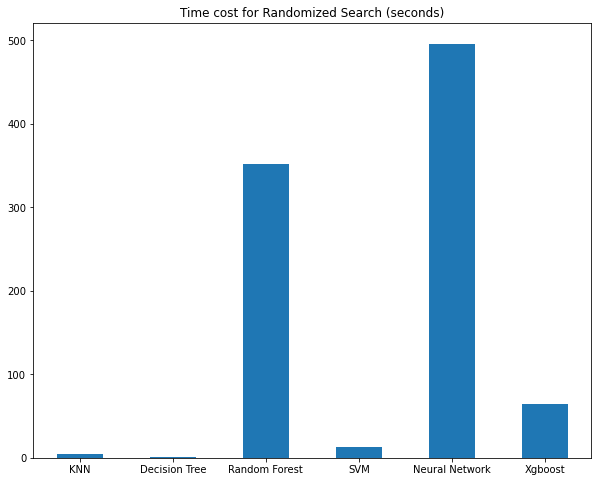

In [37]:
df_cmp.T["Time cost for Randomized Search (seconds)"].plot.bar(figsize=(10,8), rot=0, title="Time cost for Randomized Search (seconds)")

<AxesSubplot:title={'center':'R2 score for models with/without tuning'}>

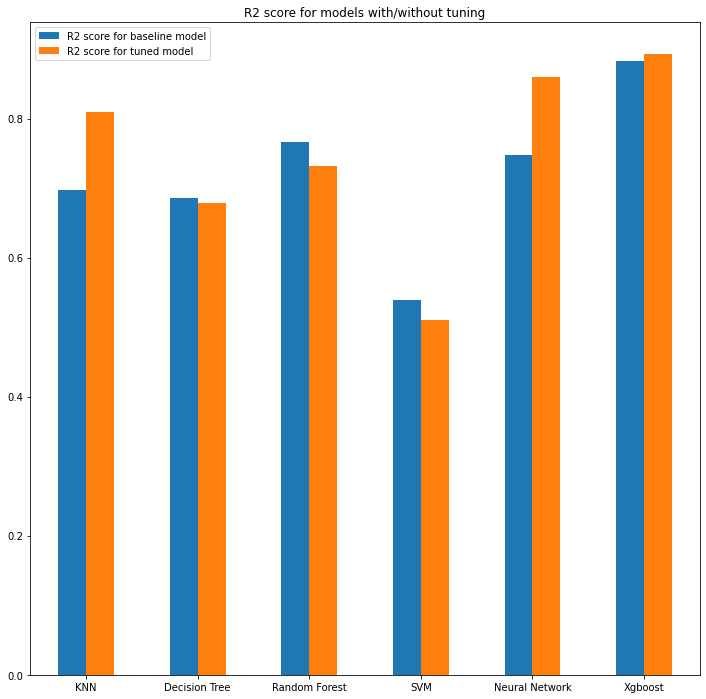

In [38]:
df_cmp.T[["R2 score for baseline model", "R2 score for tuned model"]].plot.bar(figsize=(12,12), rot=0, title="R2 score for models with/without tuning")

<font size=4>
    Combine both figures above, there're two choices after balancing time cost and prediction accuarcy:<br>
    1. KNN benefits more on time saving <br>
    2. Xgboost benefits more on accurate prediction <br>
</font>

In [27]:
y_predict = xgb_improve.predict(final_test)
output = pd.DataFrame()
output['Id'] = test_id
output['SalePrice'] = y_predict
output_path = parent_path + "/data/output/submission.csv"
output.to_csv(output_path, index=False)

C:\Users\flywi\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
C:\Users\flywi\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
